In [2]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')
from matplotlib.ticker import MaxNLocator

from matplotlib import rc
rc('text', usetex=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
from natsort import natsorted
from skimage.util import img_as_uint
from skimage.draw import disk
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation
import seaborn as sns
import pandas as pd
import sys
sys.path.insert(0, "../")
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from scipy.signal import find_peaks
from glob import glob
def bin_data(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


all_results = pd.read_pickle("../../single_molecule_analysis/sources_of_error.pickle")
hist_data = all_results.groupby(["True N molecules", "Cell type"], as_index=False).mean().melt(["Cell type", "True N molecules"])
hist_data['variable'] = pd.Categorical(hist_data['variable'], reversed(["Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]))
#ist_data = hist_data.reindex(index=hist_data.index[::-1])


In [3]:
import pickle
with open('../single_molecule_analysis/detection_probability_data.pkl', 'rb') as f:
    x_detection_probability, y_detection_probability = pickle.load(f) # deserialize using load()

with open('../single_molecule_analysis/cell_cross_section_profile.pkl', 'rb') as f:
    x_detection_probability, y_cell_cross_section_profile = pickle.load(f) # deserialize using load()


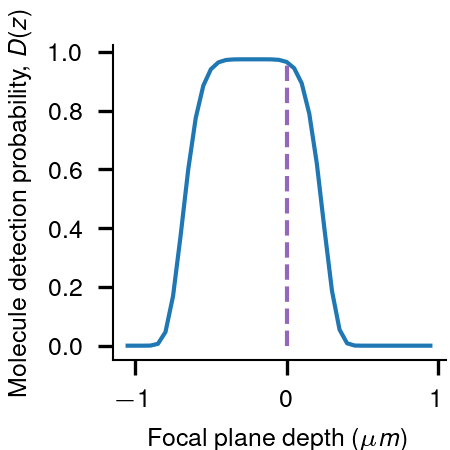

In [4]:
fig, detection_probability_fig = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=300)
plt.plot(x_detection_probability, y_detection_probability)
plt.xlabel("Focal plane depth ($\mu m$)")
plt.ylabel("Molecule detection probability, $D(z)$")
plt.plot([0,0], [0, y_detection_probability.max()], linestyle = "--", c = "tab:purple")
fig.subplots_adjust(left=0.25, bottom=0.2, right=0.99, top=0.9)
plt.savefig("b.svg")

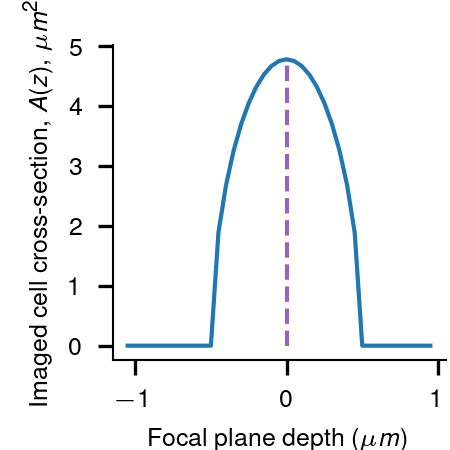

In [5]:
fig, cell_profile_fig =plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=300)
plt.plot(x_detection_probability, y_cell_cross_section_profile)
plt.xlabel("Focal plane depth ($\mu m$)")
plt.ylabel("Imaged cell cross-section, $A(z)$, $\mu m^2$")
plt.plot([0,0], [0, y_cell_cross_section_profile.max()], linestyle = "--", c = "tab:purple")

fig.subplots_adjust(left=0.25, bottom=0.2, right=0.99, top=0.9)
plt.savefig("c.svg")

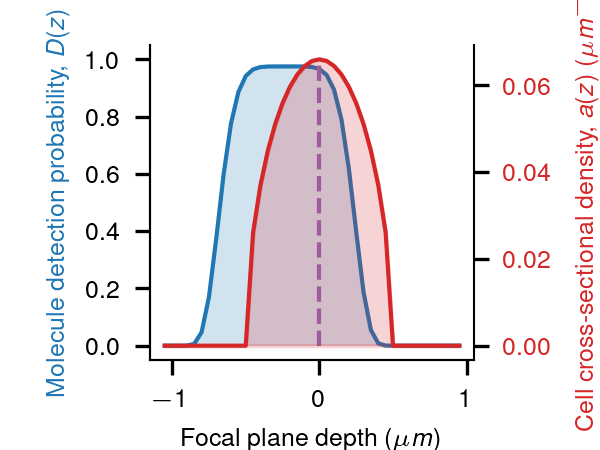

In [6]:
fig, detection_probability_fig = plt.subplots(1, 1, figsize=(2, 1.5), dpi=300)


plt.plot(x_detection_probability, y_detection_probability)
plt.xlabel("Focal plane depth ($\mu m$)")
plt.ylabel("Molecule detection probability, $D(z)$", c = "tab:blue")
plt.fill_between(x_detection_probability, y_detection_probability, alpha=0.2)  # Adjust alpha for transparency

ax2 = detection_probability_fig.twinx()
ax2.plot(x_detection_probability, y_cell_cross_section_profile/y_cell_cross_section_profile.sum(), c = "tab:red")
ax2.set_ylabel("Cell cross-sectional density, $a(z)$ ($\mu m^{-1}$)", color="tab:red")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="tab:red")
ax2.fill_between(x_detection_probability, y_cell_cross_section_profile/y_cell_cross_section_profile.sum(), alpha=0.2, color = "tab:red")  # Adjust alpha for transparency
ax2.spines[['right']].set_visible(True)
detection_probability_fig.plot([0,0], [0, 1], linestyle = "--", c = "tab:purple")

fig.subplots_adjust(left=0.25, bottom=0.2, right=0.79, top=0.9)
plt.savefig("b.svg")

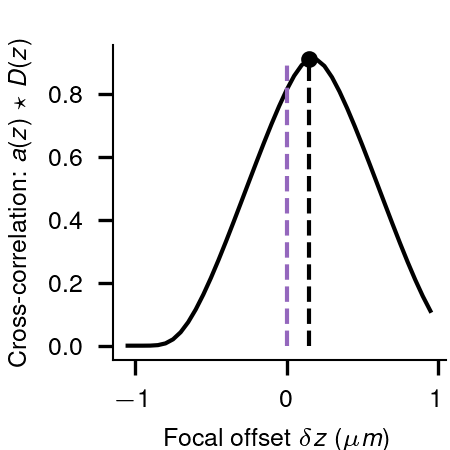

In [7]:
profile_correlation = np.correlate(y_cell_cross_section_profile/y_cell_cross_section_profile.sum(), y_detection_probability, mode = "same")
peak = find_peaks(profile_correlation)[0][0] 
fig, profile_correlation_fig = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=300)
sns.lineplot(x = x_detection_probability, y = profile_correlation, c = "k")
plt.scatter(x_detection_probability[peak], profile_correlation[peak], c = "k")
plt.plot([x_detection_probability[peak], x_detection_probability[peak]], [0, profile_correlation.max()], linestyle = "--", c = "k")
plt.xlabel("Focal offset $\delta z$ ($\mu m$)")
plt.ylabel("Cross-correlation: $a(z) \star D(z)$")
plt.plot([0,0], [0, profile_correlation.max()], linestyle = "--", c = "tab:purple")

fig.subplots_adjust(left=0.25, bottom=0.2, right=0.99, top=0.9)
plt.savefig("c.svg")

In [12]:
naive_comparison_results_1um = pd.read_pickle("../single_molecule_analysis/naive_comparison_results_1um.pickle")
naive_comparison_results_1um["Cell Radius"] = 0.5
naive_comparison_results_1um["Correction"] = "None"

#naive_comparison_results_1um_DoF_corrected = pd.read_pickle("../single_molecule_analysis/naive_comparison_results_1um_DoF_corrected.pickle")
#naive_comparison_results_1um_DoF_corrected["Cell Radius"] = 1
#naive_comparison_results_1um_DoF_corrected["Correction"] = "Focus+correction factor"

naive_comparison_results_1um_corrected = deepcopy(naive_comparison_results_1um)
naive_comparison_results_1um_corrected["Observed N molecules"] = naive_comparison_results_1um_corrected["Corrected"]
naive_comparison_results_1um_corrected["Correction"] = "Correction factor"

naive_comparison_results_MACS = pd.read_pickle("../single_molecule_analysis/naive_comparison_results_MACS.pickle")
naive_comparison_results_MACS["Cell Radius"] = 1
naive_comparison_results_MACS["Correction"] = "MACS"


naive_comparison_results = pd.concat([naive_comparison_results_1um, naive_comparison_results_1um_corrected, naive_comparison_results_MACS])

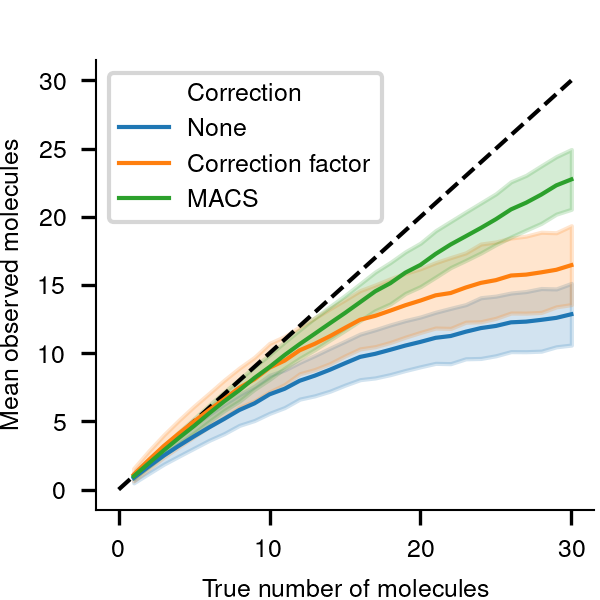

In [13]:
fig, NAIVE_1 = plt.subplots(1, 1, figsize=(2, 2), dpi=300)

plt.plot([0,30],[0,30], linestyle="--", c = "k")
plt.xlabel("True number of molecules")
plt.ylabel("Mean observed molecules")

sns.lineplot(data = naive_comparison_results, x = "True N molecules", y = "Observed N molecules", hue = "Correction", errorbar = ("sd", 1))

fig.subplots_adjust(left=0.16, bottom=0.15, right=0.99, top=0.9)
plt.savefig("d.svg")

In [76]:
test_data_dirs = natsorted(glob("../single_molecule_analysis/DEEPSTORM_MACS_test_data/*.tif"))

ground_truth_localisation = pd.read_csv("../single_molecule_analysis/DEEPSTORM_MACS_test_data/SimulatedDataset.csv")

ground_truth_counts = pd.DataFrame(ground_truth_localisation["frame"].value_counts(ascending=True)).reset_index()
ground_truth_counts.columns = ["frame", "count"]
ground_truth_counts = ground_truth_counts.sort_values(by="frame").reset_index(drop=True)

frame_IDs = ground_truth_counts["frame"].unique()

predictions = []
for frame_ID in frame_IDs:
    _ = pd.read_csv(f"../single_molecule_analysis/DEEPSTORM_MACS_test_data_predicted/Localizations_{str(frame_ID).zfill(4)}_test_avg.csv")
    _["frame"] = frame_ID
    predictions.append(
        _
    )
predicted_counts = pd.concat(predictions).query("`confidence [a.u]` > 0.35")["frame"].value_counts(ascending=True).reset_index()
predicted_counts.columns = ["frame", "count"]
predicted_counts = predicted_counts.sort_values(by="frame").reset_index(drop=True)

combined_data_MACS = pd.merge(ground_truth_counts, predicted_counts, on="frame")
combined_data_MACS.columns = ["frame", "True", "Observed"]


In [85]:
test_data_dirs = natsorted(glob("../single_molecule_analysis/DEEPSTORM_test_data/*.tif"))

ground_truth_localisation = pd.read_csv("../single_molecule_analysis/DEEPSTORM_test_data/SimulatedDataset.csv")

ground_truth_counts = pd.DataFrame(ground_truth_localisation["frame"].value_counts(ascending=True)).reset_index()
ground_truth_counts.columns = ["frame", "count"]
ground_truth_counts = ground_truth_counts.sort_values(by="frame").reset_index(drop=True)

frame_IDs = ground_truth_counts["frame"].unique()

predictions = []
for frame_ID in frame_IDs:
    _ = pd.read_csv(f"../single_molecule_analysis/DEEPSTORM_test_data_predicted/Localizations_{str(frame_ID).zfill(4)}_test_avg.csv")
    _["frame"] = frame_ID
    predictions.append(
        _
    )

predicted_counts = pd.concat(predictions).query("`confidence [a.u]` > 0.0")["frame"].value_counts(ascending=True).reset_index()
predicted_counts.columns = ["frame", "count"]
predicted_counts = predicted_counts.sort_values(by="frame").reset_index(drop=True)

combined_data = pd.merge(ground_truth_counts, predicted_counts, on="frame")
combined_data.columns = ["frame", "True", "Observed"]


/tmp/ipykernel_186755/2707156242.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_counts = pd.concat(predictions).query("`confidence [a.u]` > 0.0")["frame"].value_counts(ascending=True).reset_index()


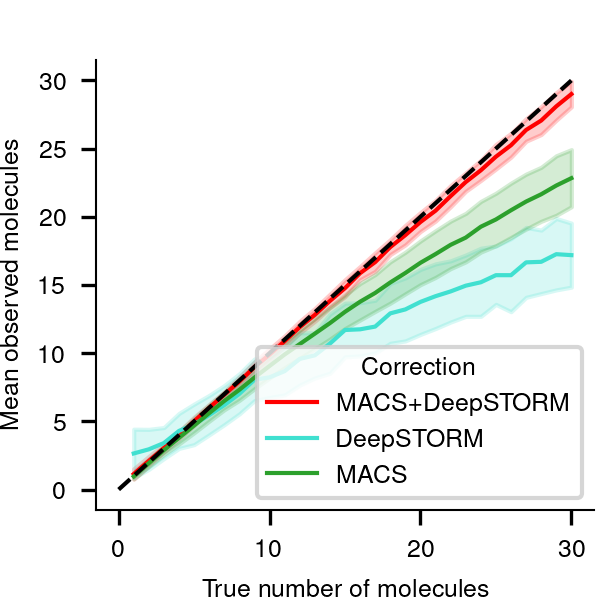

In [87]:

fig, DEEPSTORM_1 = plt.subplots(1, 1, figsize=(2, 2), dpi=300)


sns.lineplot(x = combined_data_MACS["True"], y = combined_data_MACS["Observed"], c = "r", errorbar = ("sd", 1), label = "MACS+DeepSTORM")
sns.lineplot(x = combined_data["True"], y = combined_data["Observed"], c = "turquoise", errorbar = ("sd", 1), label = "DeepSTORM")
sns.lineplot(data = naive_comparison_results.query("`Correction` == 'MACS'"), x = "True N molecules", y = "Observed N molecules", errorbar = ("sd", 1), c = "tab:green", label = "MACS")

plt.legend(title="Correction",
                    loc=4, fontsize=6, fancybox=True)


plt.xlabel("True number of molecules")
plt.ylabel("Mean observed molecules")

plt.plot([0,30],[0,30], linestyle="--", c = "k")
fig.subplots_adjust(left=0.16, bottom=0.15, right=0.99, top=0.9)

plt.savefig("e.svg")

In [40]:
pixel_size = 0.05

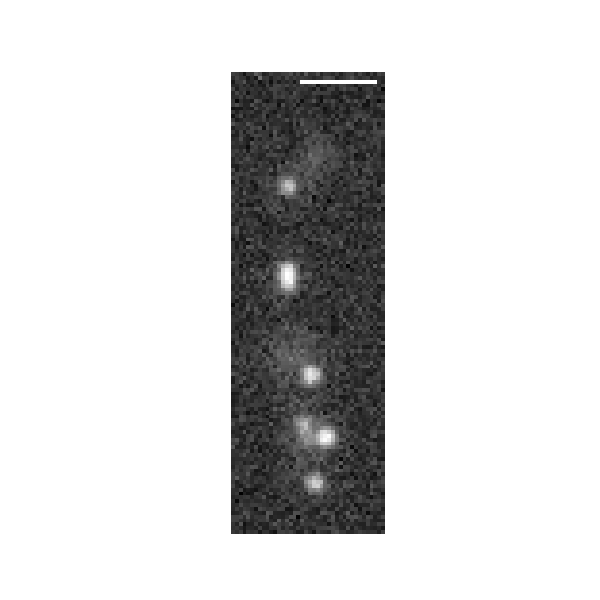

In [41]:
DS_data = tifffile.imread("../../single_molecule_analysis/DEEPSTORM_training_data/SimulatedDataset.tif")

DS_locs = pd.read_csv("../../single_molecule_analysis/DEEPSTORM_training_data/SimulatedDataset.csv")
frame = 2004
y_data, x_data = DS_locs.query("frame == @frame")["y [nm]"]/(pixel_size*1000), DS_locs.query("frame == @frame")["x [nm]"]/(pixel_size*1000)

fix, ax = plt.subplots(1, 1, figsize = (2,2), dpi = 300)
plt.imshow(DS_data[frame-1], cmap = "Greys_r")
#plt.scatter(x_data,y_data, c = "r")
scalebar = ScaleBar(pixel_size, "um", length_fraction=1, scale_loc="none",box_alpha=0, color="white", box_color="k") # 1 micon
ax.add_artist(scalebar)
plt.axis(False)
plt.savefig("normal_cell.svg")
plt.show()

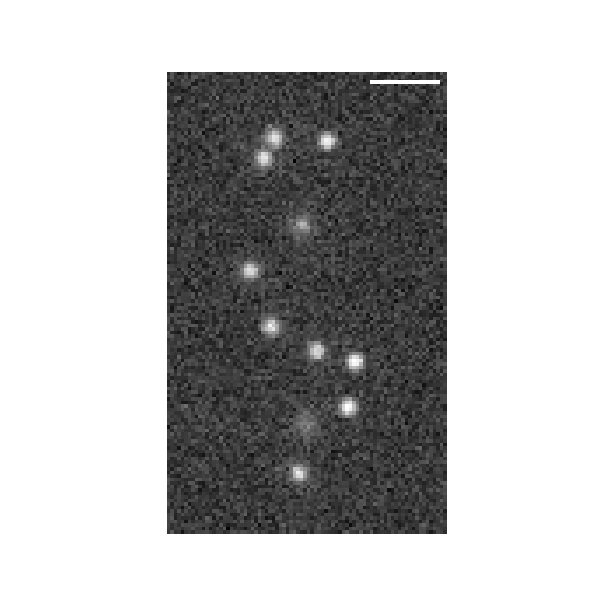

In [42]:
DS_data = tifffile.imread("../../single_molecule_analysis/DEEPSTORM_MACS_training_data//SimulatedDataset.tif")

DS_locs = pd.read_csv("../../single_molecule_analysis/DEEPSTORM_MACS_training_data/SimulatedDataset.csv")

y_data, x_data = DS_locs.query("frame == @frame")["y [nm]"]/(pixel_size*1025), DS_locs.query("frame == @frame")["x [nm]"]/(pixel_size*1025)

fix, ax = plt.subplots(1, 1, figsize = (2,2), dpi = 300)
plt.imshow(DS_data[frame-1], cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(pixel_size, "um", length_fraction=0.5, scale_loc="none",box_alpha=0, color="white", box_color="k") # 1 micon
ax.add_artist(scalebar)
plt.savefig("MACS.svg")
plt.show()

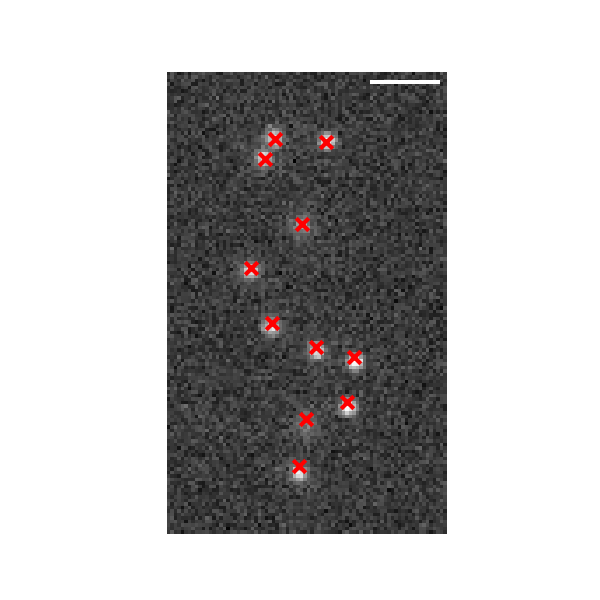

In [43]:
fix, ax = plt.subplots(1, 1, figsize = (2,2), dpi = 300)
plt.imshow(DS_data[frame-1], cmap = "Greys_r")
plt.scatter(x_data,y_data, c = "r", marker="x")
plt.axis(False)
scalebar = ScaleBar(pixel_size, "um", length_fraction=0.5, scale_loc="none",box_alpha=0, color="white", box_color="k") # 1 micon
ax.add_artist(scalebar)
plt.savefig("MACS_localised.svg")
plt.show()

In [25]:
naive_comparison_results_1um = pd.read_pickle("../single_molecule_analysis/naive_comparison_results_1um.pickle")
naive_comparison_results_1um["Cell Radius"] = "0.5 $\mu m$"
naive_comparison_results_2um = pd.read_pickle("../single_molecule_analysis/naive_comparison_results_2um.pickle")
naive_comparison_results_2um["Cell Radius"] = "1.0 $\mu m$"

SI_data = pd.concat([naive_comparison_results_1um, naive_comparison_results_2um])



In [32]:
melted = SI_data.melt(
    id_vars=["True N molecules", "Cell Radius"], 
    value_vars=["Observed N molecules", "Corrected"],
    var_name="Count type",
    value_name="Count"
)

melted['Count type'] = melted['Count type'].replace({'Observed N molecules': 'Observed', 'Corrected': 'Corrected'})


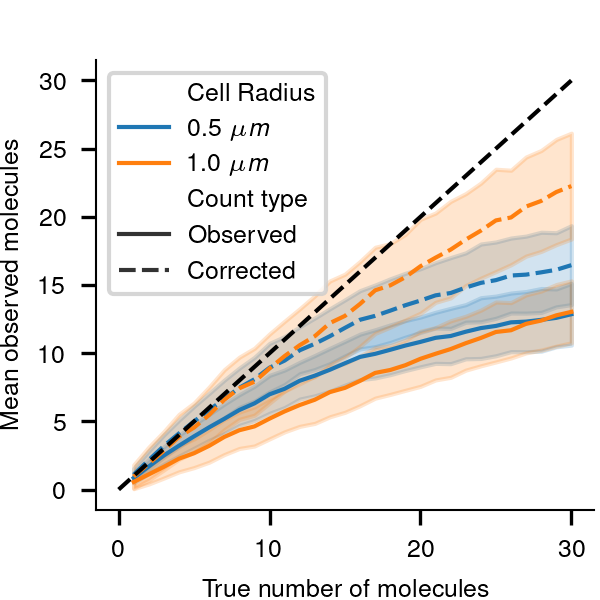

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)

sns.lineplot(data=melted, x = "True N molecules", y = "Count", hue= "Cell Radius", style="Count type", errorbar=("sd", 1))

plt.xlabel("True number of molecules")
plt.ylabel("Mean observed molecules")

plt.plot([0,30],[0,30], linestyle="--", c = "k")
fig.subplots_adjust(left=0.16, bottom=0.15, right=0.99, top=0.9)
plt.savefig("SI_1.png")